In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special

from estimator_model.causal_tree import CausalTree

ModuleNotFoundError: No module named 'estimator_model.tree_criterion'

In [ ]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + np.random.normal(0, .5, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [ ]:
adjustment = []
outcome = 'outcome'
treatment = 'treatment'
data_dict = {
    'treatment': T.reshape(-1,),
    'outcome': y.reshape(-1, ),
}
test_data_dict = {}
for i in range(X.shape[1]):
    data_dict[f'w_{i}'] = X[:, i].reshape(-1, )
    test_data_dict[f'w_{i}'] = X_test[:, i].reshape(-1, )
    adjustment.append(f'w_{i}')
data = pd.DataFrame(data_dict)
test_data = pd.DataFrame(test_data_dict)
data.head()

,treatment,outcome,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
0,0.0,0.313885,-1.085631,0.997345,0.282978,-1.506295,-0.578600,1.651437,-2.426679,-0.428913,1.265936,-0.866740
1,0.0,-0.306026,-0.678886,-0.094709,1.491390,-0.638902,-0.443982,-0.434351,2.205930,2.186786,1.004054,0.386186
2,1.0,0.909253,0.737369,1.490732,-0.935834,1.175829,-1.253881,-0.637752,0.907105,-1.428681,-0.140069,-0.861755
3,0.0,-0.271350,-0.255619,-2.798589,-1.771533,-0.699877,0.927462,-0.173636,0.002846,0.688223,-0.879536,0.283627
4,0.0,0.000403,-0.805367,-1.727669,-0.390900,0.573806,0.338589,-0.011830,2.392365,0.412912,0.978736,2.238143


In [ ]:
data[treatment].value_counts()

0.0    1020
1.0     980
Name: treatment, dtype: int64

In [ ]:
ct = CausalTree()
ct.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment
)
ct_pred = ct.estimate(data=test_data)

NameError: name 'CMSE' is not defined

In [ ]:
ct.tree.predict(ct._wv.astype(np.float32))

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

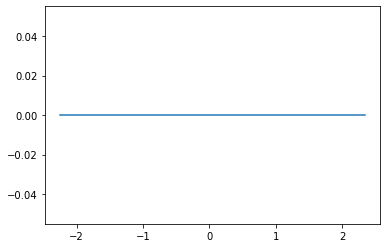

In [ ]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], ct_pred[:, t])
plt.show()

In [ ]:
0 / (0 + 1e-5)

0.0

In [ ]:
     
     cdef double node_impurity(self) nogil:
        """Evaluate the impurity of the current node.
        Evaluate the CMSE criterion as impurity of the current node,
        i.e. the impurity of samples[start:end]. The smaller the impurity the
        better.
        """
        cdef double impurity

        cdef SIZE_t start = self.start
        cdef SIZE_t end = self.end
        cdef SIZE_t i
        cdef SIZE_t p
        cdef DOUBLE_t y_ik
        cdef DOUBLE_t w

        cdef SIZE_t* samples = self.samples
        cdef DOUBLE_t* sample_weight = self.sample_weight

        cdef double n_t = 0.0  # number of treatment examples
        cdef double n_0 = 0.0  # number of control examples
        cdef double yt_sum = 0.0  # sum of yt
        cdef double y0_sum = 0.0  # sum of y0
        cdef double yt_sq_sum = 0.0  # sum of yt^2
        cdef double y0_sq_sum = 0.0  # sum of y0^2
        cdef double mu_t  # estimation of yt
        cdef double mu_0  # estimation of y0
        cdef double var_t  # variance of the treatment group
        cdef double var_0  # variance of the control group
        cdef double tau

        n_t = self.weighted_n_node_samples - (end - start + 1)
        n_0 = (end - start + 1) - n_t
        
        for p in range(start, end):
            i = samples[p]
            
            y_ik = self.y[i, 0]
            yt_sum += y_ik
            yt_sq_sum += y_ik * y_ik
        
        yt_sum = self.sum_total[0] - yt_sum
        y0_sum = self.sum_total[0] - 2 * yt_sum

        yt_sq_sum = self.sq_sum_total - yt_sq_sum
        y0_sq_sum = self.sq_sum_total - 2 * yt_sq_sum

        mu_t = yt_sum / n_t
        mu_0 = y0_sum / n_0
        tau = mu_t - mu_0
        var_t = yt_sq_sum / n_t - mu_t * mu_t
        var_0 = y0_sq_sum / n_0 - mu_0 * mu_0
        impurity = -tau * tau + (var_t / n_t + var_0 / n_0)

        self.reset()

        return impurity

SyntaxError: invalid syntax (2460608234.py, line 1)

In [ ]:
    cdef void node_value(self, double* dest) nogil:
        """Compute the node value of samples[start:end] into dest."""
        
        cdef SIZE_t start = self.start
        cdef SIZE_t end = self.end
        cdef SIZE_t i
        cdef SIZE_t p
        cdef DOUBLE_t y_ik
        cdef DOUBLE_t w

        cdef SIZE_t* samples = self.samples
        cdef DOUBLE_t* sample_weight = self.sample_weight

        cdef double n_t = 0.0  # number of treatment examples
        cdef double n_0 = 0.0  # number of control examples
        cdef double y0_sum = 0.0  # sum of y0
        
        n_t = self.weighted_n_node_samples - (end - start + 1)
        n_0 = (end - start + 1) - n_t

        for p in range(start, end):
            i = samples[p]

            y_ik = self.y[i, 0]
            yt_sum += y_ik
        
        yt_sum = self.sum_total[0] - yt_sum
        y0_sum = self.sum_total[0] - 2 * yt_sum
        
        dest[0] = yt_sum / n_t - y0_sum / n_0
        
        self.reset()

In [ ]:
# # Helper imports 
# import numpy as np
# from numpy.random import binomial, multivariate_normal, normal, uniform
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
# import matplotlib.pyplot as plt
# import pandas as pd

# from estimator_model.meta_learner import SLearner, TLearner, XLearner
# from estimator_model.doubly_robust import DoublyRobust

# %matplotlib inline

In [ ]:
# Define DGP
# def generate_data(n, d, controls_outcome, treatment_effect, propensity):
#     """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
#     Parameters
#     ----------
#         n (int): population size
#         d (int): number of covariates
#         controls_outcome (func): untreated outcome conditional on covariates
#         treatment_effect (func): treatment effect conditional on covariates
#         propensity (func): probability of treatment conditional on covariates
#     """
#     # Generate covariates
#     X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
#     # Generate treatment
#     T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
#     # Calculate outcome
#     Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
#     treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
#     Y = Y0 + treat_effect * T
#     return (Y, T, X)

In [ ]:
# def generate_controls_outcome(d):
#     beta = uniform(-3, 3, d)
#     return lambda x: np.dot(x, beta) + normal(0, 1)
# treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
# propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)
# # DGP constants and test data
# d = 5
# n = 1000
# n_test = 250
# controls_outcome = generate_controls_outcome(d)
# X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
# delta = 6/n_test
# X_test[:, 1] = np.arange(-3, 3, delta)

In [ ]:
# y, x, w = generate_data(n, d, controls_outcome, treatment_effect, propensity)
# data_dict = {
#     'outcome': y,
#     'treatment': x,
# }
# test_dict = {}
# adjustment = []
# for i in range(w.shape[1]):
#     data_dict[f'w_{i}'] = w[:, i].squeeze()
#     test_dict[f'w_{i}'] = X_test[:, i].squeeze()
#     adjustment.append(f'w_{i}')
# outcome = 'outcome'
# treatment = 'treatment'
# data = pd.DataFrame(data_dict)
# test_data = pd.DataFrame(test_dict)

In [ ]:
# ct = CausalTree(min_samples_leaf=2)
# ct.fit(
#     data=data,
#     outcome=outcome,
#     treatment=treatment,
#     adjustment=adjustment
# )